In [1]:
import os
from typing import Tuple, List, Iterable, Callable

import math
import time
import numpy as np
import pandas as pd
from scipy.stats import halfcauchy, invgamma
import cvxpy as cp
from matplotlib import pyplot as plt
from scipy import stats

from scipy.stats import multivariate_normal
from numpy.random import default_rng
from itertools import chain, combinations, product

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)

In [65]:
def powerset(x:Iterable):
    '''
    Powerset (set of subsets) for a given iterable x incl. ∅
    '''
    s = list(x)
    powerSet = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    
    return list(powerSet)

class Oracle:
    def __init__(self, fun, sigma_2:float=0.0, N_total:int=100_000, seed:int=0):
        assert isinstance(fun, Callable), "Input `f` must be a callable function."
        assert isinstance(sigma_2, float) and sigma_2>=0, "Input `sigma_2` must be a non-negative float."
        assert isinstance(seed, int), "Input `seed` must be an integer."
        
        self.fun = fun
        self.sigma_2 = sigma_2
        self.seed = seed
        self.N_total = N_total
        self.N_current = 0
        
        np.random.seed(self.seed)
        
    def __expandX__(self, x:np.array) -> np.array:
        '''
        Expand original input format {1,...,d} -> {0} + {1,...,d} + {... (d over 2) ... }
        '''
        
        # transform
        if(len(x.shape)==2 and len(x)>1):
            quad_x = np.stack([x[:,pair[0]] * x[:,pair[1]] for pair in powerset(range(x.shape[1])) if len(pair)==2], axis=1)
            assert len(quad_x)==len(x) and math.comb(len(x), 2), "Inconsistent dimension for the resulting design matrix of quadratic terms"
            x = np.concatenate((x, quad_x), axis=1)
        else:
            x = np.array(list(x) + [float(x[pair[0]] * x[pair[1]]) for pair in powerset(range(len(x))) if len(pair)==2])
            x = np.array([1] + list(x), dtype=float)
        
        return x
    
    def f(self, x:np.array, noiseFlag:bool=True):
        '''
        Returns (noisy) function value of function f
        '''
    
        # expand raw input
        x = self.__expandX__(x)
        
        if(len(x.shape)==2 and len(x)>1):
            assert self.N_current + len(x) <= self.N_total, f"Limit of `N_total`={self.N_total} will be exceeded as {self.N_current} calls where made and this request requires another {len(x)} function calls."
            self.N_current += len(x)
            if(noiseFlag):
                return np.array([self.fun(x_) for x_ in x]) + np.random.normal(loc=0, scale=np.sqrt(self.sigma_2), size=len(x))
            else:
                return np.array([self.fun(x_) for x_ in x])
        else:
            assert self.N_current + 1 <= self.N_total, f"Limit of `N_total`={self.N_total} will be exceeded as {self.N_current} calls where made and this request requires another {len(X)} function calls."
            self.N_current += 1
            if(noiseFlag):
                return self.fun(x)+float(np.random.normal(loc=0, scale=np.sqrt(self.sigma_2), size=1))
            return self.fun(x)
        
class SparseBayesReg:

    d_MAX = 20
    
    def __init__(self, N_total:int, seed:int, burnin:int, thinning:int):

        assert isinstance(seed, int), "`seed` must be an integer."
        assert isinstance(burnin, int) and burnin>=0, "`burnin` must be a non-negative integer."
        assert isinstance(thinning, int) and thinning>=1, "`thinning` must be an positive integer."
        
        # - assignment
        self.N_total = N_total
        self.seed = seed
        self.burnin = burnin
        self.thinning = thinning
        
    def setXy(self, X:np.array, y:np.array) -> None:
        '''
        Setup of design matrix X (standardized, incl. leading 1-column and quadratic terms) and target vector y (transalted to E[y]=0)
        '''
        assert sum(X[:,0])!=len(X), "Provide the design matrix X without adding a leading 1-column (for intercept)"
        
        self.d = X.shape[1]
        self.p = 1 + self.d + math.comb(self.d, 2)
        
        assert isinstance(self.d, int) and 0<self.d<=self.d_MAX, f"The inferred dimension `d`={self.d} should be smaller than {self.d_MAX}"
        
        self.__expandX__(X)
        self.__standardizeX__()
        self.__standardizeX__()
        self.__interceptColumnX__()

        self.__translateY__(y)
    
    def __expandX__(self, X:np.array) -> None:
        '''
        Given a (binary) design matrix X, it appends pairwise products of columns and appends to the design matrix X;
        *excluding* the leading intercept column of 1's
        '''
        
        # quadratic terms
        quad_X = np.stack([X[:,pair[0]] * X[:,pair[1]] for pair in powerset(range(X.shape[1])) if len(pair)==2], axis=1)

        assert len(quad_X)==len(X) and math.comb(len(X), 2), "Inconsistent dimension for the resulting design matrix of quadratic terms"

        self.X = np.concatenate((X, quad_X), axis=1)

    def __standardizeX__(self) -> None:
        '''
        Standardizes (translates & rescales) the columns of the design matrix (input matrix) 
        '''

        X = self.X
        assert X.shape[1]==self.p-1, "The given design matrix includes a leading 1-column; unclear if it is a legitimiate (coincidental) feature or leading 1 column was already incldued"

        X_mu, X_sigma = X.mean(axis=0), X.std(axis=0)
        X_new = (X - X_mu) /  X_sigma

        self.X_mu = X_mu
        self.X_sigma = X_sigma #np.sqrt(len(X)) * X_sigma  # corrected for sqrt(n)
        self.X = X_new
        
    def __interceptColumnX__(self) -> np.array:
        '''
        Adds a leading vector of 1s to the binary matrix X (of 1st and 2nd order interactions)
        '''
        
        X = self.X
        X = np.concatenate((np.ones_like(X[:,0]).reshape(-1,1), X), axis=1)

        assert X.shape[1]==self.p, "Inconsistent number of columns after adding leading 1-col"

        self.X = X

    def __translateY__(self, y:np.array) -> None:
        '''
        Translation of the target vector y such that priori condition E[y]=0 is satisfied.
        (No rescaling to unit variance is applied, though.)
        '''
        X = self.X

        assert len(X) == len(y), "Length of target vector y does not coincide with design matrix X"

        # Standardize y's
        y_mu = np.mean(y)
        y_new = y - y_mu
        
        self.y_mu = y_mu
        self.y = y_new
        
    def add(self, x_new:np.array, y_new:float, fitFlag:bool=True) -> None:
        '''
        Appends new datapoint to X,y
        '''

        assert len(x_new.shape)==1 and len(x_new)==self.d, f"Input has dimension {x_new.shape} but ({self.d},) was expected."

        # X : expand, standardize, append leading 1
        x_new_exp = np.array(list(x_new) + [float(x_new[pair[0]] * x_new[pair[1]]) for pair in powerset(range(len(x_new))) if len(pair)==2])
        x_new_exp = (x_new_exp - self.X_mu) / self.X_sigma
        
        x_new_exp = np.array([1] + list(x_new_exp), dtype=float)
        self.X = np.append(arr=self.X, values=x_new_exp.reshape(1,-1), axis=0)

        # de-bias
        self.y = np.append(arr=self.y, values=(y_new - self.y_mu))
        
        # re-fit
        if(fitFlag):
            self.__fit__()
    
    def __mvg__(self, Phi, alpha, D):
        '''
        Sample multivariate Gaussian (independent of d) from NumPy
        Not used Rue (2001) or et. al. (2015) approaches on fast sampling mvg
        N(mean = S@Phi.T@y, cov = inv(Phi'Phi + inv(D))
        '''
        #assert len(Phi.shape)==2 and Phi.shape[0]==Phi.shape[1], "`Phi` must be a quadratic matrix."
        assert len(D.shape)==2 and D.shape[0]==D.shape[1], "`D` must be a quadratic matrix."
        
        S = np.linalg.inv(Phi.T @ Phi + np.linalg.inv(D))
        x = np.random.multivariate_normal(mean=((S @ Phi.T) @ y), cov=S, size=1)
        
        return x
    
    def sampleAlpha(self) -> np.array:
        '''
        Samples posterior  ~ P( |X,y) from (most current) posterior distribution
        '''
        alpha_post = np.random.multivariate_normal(mean = self.alpha_mu,
                                                   cov  = self.alpha_cov,
                                                   size = 1).reshape(-1)
        
        return alpha_post
    
    def __fit__(self) -> None:
        '''
        Core of fitting procedure (on self.X, self.y)
        '''
        
        # D0
        self.n = len(self.X)
        
        # setup values
        alphas_out = np.zeros((self.p, 1))
        s2_out     = np.zeros((1, 1))
        t2_out     = np.zeros((1, 1))
        l2_out     = np.zeros((self.p, 1))

        # sample priors
        betas   = halfcauchy.rvs(size=self.p) 
        tau_2   = halfcauchy.rvs(size=1)                            
        nu      = np.ones(self.p) # ?
 
        sigma_2, xi = 1.0, 1.0
        
        # Gibbs sampler
        for k in range(self.N_total):
            #print('k=')
            # std. deviation
            sigma = np.sqrt(sigma_2)

            # alphas
            # - Sigma_star
            Sigma_star = tau_2 * np.diag(betas**2) # Sigma_star
            Sigma_star_inv = np.linalg.inv(Sigma_star)
            # - A
            A     = (self.X.T @ self.X) + Sigma_star_inv
            A_inv = np.linalg.inv(A)
            
            # - update posterior mean, cov
            self.alpha_mu  = A_inv @ self.X.T @ self.y
            self.alpha_cov = sigma_2 * A_inv
            # - sample alpha
            alphas = self.sampleAlpha()
            
            # sigma_2
            sigma_2 = invgamma.rvs(0.5*(self.n+self.p), scale=0.5*(np.linalg.norm((self.y - self.X @ alphas), 2)**2 + (alphas.T @ Sigma_star_inv @ alphas)))

            
            # - betas
            betas_2 = invgamma.rvs(np.ones(self.p), scale=(1. / nu) + (alphas**2)/(2 * sigma_2 * tau_2))
            betas = np.sqrt(betas_2)

            # - tau_2
            tau_2 = invgamma.rvs(0.5*(self.p+1), scale=1.0 / xi + (1. / (2. * sigma_2)) * sum(alphas**2 / betas**2), size=1)

            # - nu
            nu = invgamma.rvs(np.ones(self.p), scale=1.0 + betas**(-2), size=self.p)

            # - xi
            xi = invgamma.rvs(1.0, scale=1.0 + 1.0 / tau_2, size=1)
            
            # store samples
            if k > self.burnin:
                # - append
                if(k%self.thinning==0):
                    alphas_out = np.append(arr=alphas_out, values=alphas.reshape(-1,1), axis=1)
                    s2_out = np.append(s2_out, sigma_2)
                    t2_out = np.append(t2_out, tau_2)
                    l2_out = np.append(arr=l2_out, values=betas.reshape(-1,1), axis=1)

        # Clip 1st value
        self.alphas = alphas_out[:,1:]
        self.s2 = s2_out[1:]
        self.t2 = t2_out[1:]
        self.l2 = l2_out[1:]
        
    def getAlphas(self) -> np.array:
        '''
        Returns current array of alpha posterior samples
        '''
        return self.alphas
    
    def fit(self, X:np.array, y:np.array) -> None:
        '''
        Fitting the (initial) model on the data D0={X0,y0}
        '''
        assert len(X.shape)==2 and len(y.shape)==1, "Design matrix X and target vector y."
        assert X.shape[0]==len(y), f"Dimension of design matrix X and target vector y do not coincide: X.shape[1]={X.shape[1]}!={len(y)}=len(y)"
        assert len(X) < self.N_total, f"Implied `N_init`=len(X)={len(X)} exceeds `N_total`={self.N_total}."
        
        # setup
        self.setXy(X, y)
        
        # fitting
        self.__fit__()
        
        

class SDP:
    penOrdList = [1, 2]
    optModes = ['min', 'max']
    d_MAX = 20
    
    def __init__(self, alpha:np.array, lambd:float=0.1, pen_ord:int=2, mode:str='min') -> List[np.array]:
        
        assert isinstance(mode, str), "Input `mode` must be a str either `min` or `max`."
        mode = mode.lower()
        assert mode in self.optModes, "Input `mode` is str. In addition, it must be a str either `min` or `max`."
        assert isinstance(lambd, float) and lambd >=0, "lambda (regularization parameter) must be non-negative scalar."
        assert pen_ord in self.penOrdList, "Only l=1 or l=2 supported for `pen_ord`"
        
        self.mode = mode
        self.lambd = lambd
        self.pen_ord = pen_ord
        self.alpha = alpha
        
        # infer d(imension)
        self.p = len(self.alpha)
        dDict = {1+dLoc+math.comb(dLoc,2) : dLoc for dLoc in range(1,self.d_MAX+1)}
        if(self.p in dDict.keys()):
            self.d = dDict[self.p]
        else:
            assert False, f'Length of `alpha` is not a 1+d+binom(d,2) for any 1,2,...,{self.d_MAX}'
        assert isinstance(self.d, int), "Dimension `d` must be non-negative integer."
        
        #print('self...d: ', self.d)
        
        # extract 1st/2nd order terms
        b = self.alpha[1:1 + self.d]  # 1st
        a = self.alpha[1 + self.d:]   # 2nd

        # get indices for quadratic terms
        idx_prod = np.array(list(combinations(np.arange(self.d), 2)))
        d_idx = idx_prod.shape[0]

        # check number of coefficients
        if len(a)!=d_idx:
            assert False, 'Number of Coefficients does not match indices!'

        # xAx-term
        A = np.zeros((self.d, self.d))
        for i in range(d_idx):
            A[idx_prod[i,0], idx_prod[i,1]] = 0.5 * a[i]
        A += A.T

        # bx-term
        bt = 0.5 * (b + A @ np.ones(self.d)).reshape((-1, 1))
        bt = bt.reshape((self.d, 1))
        At = np.vstack((np.append(0.25*A, 0.25*bt, axis=1), np.append(bt.T, 2.)))
        
        self.A  = A
        self.b  = b
        self.At = At
        self.bt = bt
        
    def run(self) -> np.array:
        '''
        Runs the BQP-relaxation, SDP-optimization, and extracts candidate x via geometric rounding
        '''
        self.solve()
        self.decompose()
        return self.geometricRounding()
        
        
    def solve(self, ) -> None:
        '''Solve SDP'''
        # SDP relaxation
        Xvar = cp.Variable((self.d+1, self.d+1), PSD=True)
        
        # - objective function
        if(self.mode=='min'):
            f0 = cp.Minimize(cp.trace((self.At @ Xvar)))
        else:
            f0 = cp.Maximize(cp.trace((self.At @ Xvar)))
        
        # - constraints
        constraints = [cp.diag(Xvar) == np.ones(self.d+1)]
        prob = cp.Problem(f0, constraints)
        prob.solve()
        
        self.Xvar = Xvar
        
    def decompose(self) -> None:
        '''
        Wrapper for stable Cholesky decomposition
        '''
        self.L = self.__stableCholesky__(eTol=1E-12)
    
    def __stableCholesky__(self, eTol:float=1E-10) -> np.array:
        '''
        Performs numerically stable Cholesky decomposition (by adding regularity to the matrix until PSD). 
        '''
        try:
            return np.linalg.cholesky(self.Xvar.value + eTol*np.eye(self.Xvar.value.shape[0]))
        except Exception as e:
            if(isinstance(e, np.linalg.LinAlgError)):
                return self.__stableCholesky__(10*eTol)
            else:
                pass
    
    def geometricRounding(self, k_rounds:int=100) -> np.array:
        '''
        Random geometric round and conversion to original space
        - k_rounds: number of iterations
        '''
        x_cand  = np.zeros((self.d, k_rounds))
        f_star  = np.zeros(k_rounds)

        for j in range(k_rounds):
            # rnd cutting plane vector (U on Sn) 
            r = np.random.randn(self.d+1)
            r /= np.linalg.norm(r, ord=2)
            
            # rnd hyperplane
            y_star = np.sign(self.L.T @ r)

            # convert solution to original domain and assign to output vector
            x_cand[:,j] = 0.5 * (1.0 + y_star[:self.d])
            f_star[j] = (x_cand[:,j].T @ self.A @ x_cand[:,j]) + (self.b @  x_cand[:,j])

            # Find optimal rounded solution
            if(self.mode=='min'):
                f_argopt = np.argmin(f_star)
            else:
                f_argopt = np.argmax(f_star)
            x_0      = x_cand[:,f_argopt]
            f_0      = f_star[f_argopt]

        return (x_0, f_0)

In [102]:
class BOCS:
    variantList = ['SDP', 'SA']
    optModes = ['min', 'max']
    
    def __init__(self, variant:str='SDP', oracle:Oracle, N:int, B:int=0, T:int=1, seed:int=0,
                 lambd:float=0.5, pen_ord:int=2, mode:str='min'):
        
        assert variant is in self.variantList, f"AFO `variant` must be in: {', '.join(variantList)}"
        
        self.variant = variant
        self.N = N
        self.seed = seed
        self.B = B
        self.T = T
        self.lambd = lambd
        self.pen_ord = pen_ord
        self.mode = mode
        self.oracle = oracle
        
        # init Sparse Bayesian Regression
        self.BayReg = SparseBayesReg(N_total=self.N, burnin=self.B, thinning=self.T, seed=self.seed)
        
    def fit(self, X:np.array, y:np.array) -> None:
        '''
        Delegate fit to bayesian regression model
        '''
        self.BayReg.setXy(X,y)
        self.BayReg.fit(X,y)
        
    def update(self,):
        '''
        Sample alpha from Bayesian regression, solve SDP, return cancidate x & (noisy) oracle function value y
        '''
        alpha_t = self.BayReg.sampleAlpha()
        
        # SDP update
        if(self.variant=='SDP'):
            self.sdp = SDP(alpha=alpha_t, lambd=self.lambd, pen_ord=self.pen_ord, mode=self.mode)
            x_new, y_new_hat = self.sdp.run()
            y_new = self.oracle.f(x_new)
        elif(self.variant=='SA'):
            pass
        else:
            assert False, "Not implemented"
        
        # update model
        self.BayReg.add(x_new, y_new)
        
        return x_new, y_new
    
class RandomSearch():
    d_MAX = 20
    
    def __init__(self, oracle:Oracle, d:int, seed:int=0):
        assert isinstance(d, int) and 0<d<self.d_MAX, f"Dimension `d` must be non-negative integer smaller than {self.d_MAX}"
        
        self.oracle = oracle
        self.d = d
        self.seed = seed
        
        np.random.seed(self.seed)
    
    def update(self,):
        '''
        Sample random x (& noisy oracle function value) y
        '''
        x_new = np.random.binomial(n=1, p=0.5, size=self.d)
        y_new = self.oracle.f(x=x_new)
        return x_new, y_new
    

In [175]:
sa1 = SA(oracle=orc1, N=50, d=6, Tfac=0.8, mode='min')

X, y = sa1.run()
y

array([ -8.56949875,  -8.56949875,  -8.56949875,  -8.56949875,
       -21.93903195, -21.93903195, -21.93903195, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -25.89839638, -25.89839638, -25.89839638,
       -25.89839638, -26.31134151, -26.31134151, -26.31134151,
       -26.31134151, -26.31134151, -26.31134151, -26.31134151,
       -26.31134151, -26.31134151, -26.31134151, -26.31134151,
       -26.31134151, -26.31134151])

In [129]:
rndIndex = np.random.randint(self.d)

4

In [223]:
# Frequentist Version
# - - - - - - - - - - -
# Problem
d  = 10
n  = 20
n1 = 100

#
dictBOCS = {}
dictRND = {}
for j in range(100): 
    try:
        # oracle
        np.random.seed(16*j+600)
        coef = np.random.normal(loc=0, scale=5, size=1+d+math.comb(d,2))
        orc1 = Oracle(fun= lambda x: sum([coef[i] * x[i] for i in range(len(x)-1)]), sigma_2=3.0, N_total=100_000_000)

        # D0
        np.random.seed(j)
        X = np.random.binomial(n=1,p=0.5, size=n*d).reshape((n,d))
        y = orc1.f(X)

        # BOCS
        bocs = BOCS(oracle=orc1, N=200, B=10, T=2)
        bocs.fit(X,y)

        # Random Search
        rndS = RandomSearch(oracle=orc1, d=d)

        # SMAC

        # L2S-DISCO

        BocsfList = [0]
        RndList = [0]
        for i in range(n1):
            # BOCS
            x_, y_ = bocs.update()
            BocsfList.append(min(y_, min(BocsfList)))

            # Random Search
            x_, y_ = rndS.update()
            RndList.append(min(y_, min(RndList)))

        # re-scale
        y_MAX = max(max(BocsfList), max(RndList))
        y_MIN = min(min(BocsfList), min(RndList))

        # update
        BocsfList = BocsfList / (y_MAX - y_MIN)
        RndList = RndList / (y_MAX - y_MIN)

        # update
        dictBOCS[j] = BocsfList
        dictRND[j]  = RndList
    except:
        pass



/var/folders/r2/qhw24dkn7zd0pk46l7kps5jm0000gn/T/ipykernel_56077/2187521957.py:118: RuntimeWarning: invalid value encountered in true_divide
  X_new = (X - X_mu) /  X_sigma


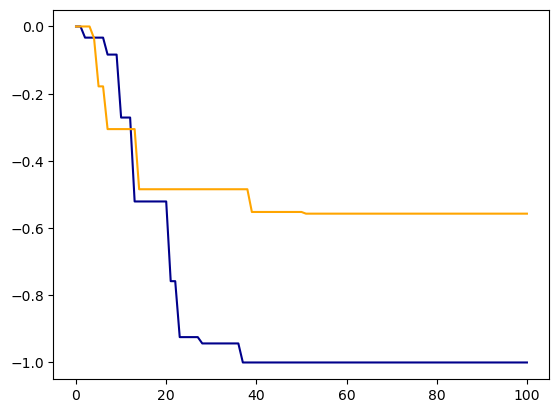

In [224]:
# RANGE
y_MAX = max(max(BocsfList), max(RndList))
y_MIN = min(min(BocsfList), min(RndList))

# update
BocsfList = BocsfList / (y_MAX - y_MIN)
RndList = RndList / (y_MAX - y_MIN)

# Plot
plt.plot(BocsfList / (y_MAX - y_MIN), color='darkblue')
plt.plot(RndList / (y_MAX - y_MIN), color='orange')
plt.show()

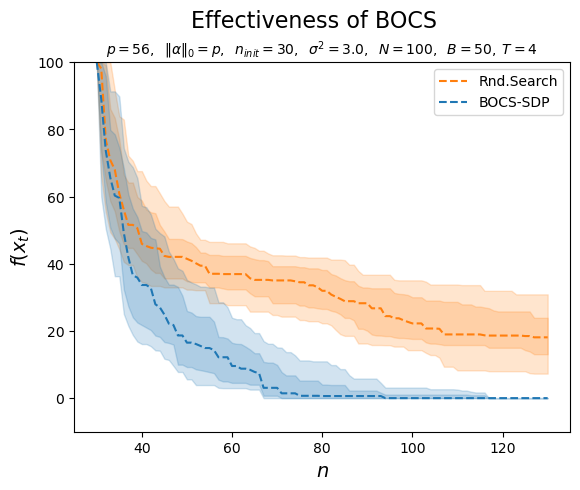

In [243]:
# Plot
fig,ax = plt.subplots()
x_ = np.array(range(30, 131))
  
mult, inter = 100, 1
q1,q2 = 0.35, 0.65
q10, q90 = 0.25, 0.75
    
# mean
y_mean  = ((np.array(pd.DataFrame(dictRND).quantile(0.5, axis=1)))+inter)*mult
ax.plot(x_, y_mean, '--', color='tab:orange')

#plt.plot(range(20, 20+len(mseDict[0])), [mse_**2 for mse_ in mse])
plt.xticks()

# compute upper lower
y_lower = (np.array(pd.DataFrame(dictRND).quantile(q10, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictRND).quantile(q90, axis=1))+inter)*mult
        
# plot our confidence band
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:orange')

# compute upper lower
y_lower = (np.array(pd.DataFrame(dictRND).quantile(q1, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictRND).quantile(q2, axis=1))+inter)*mult
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:orange')

# compute upper lower
y_lower = (np.array(pd.DataFrame(dictBOCS).quantile(q10, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictBOCS).quantile(q90, axis=1))+inter)*mult
        
# plot our confidence band
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:blue')

# compute upper lower
y_mean  = (np.array(pd.DataFrame(dictBOCS).quantile(0.5, axis=1))+inter)*mult
ax.plot(x_, y_mean, '--', color='tab:blue')
y_lower = (np.array(pd.DataFrame(dictBOCS).quantile(q1, axis=1))+inter)*mult
y_upper = (np.array(pd.DataFrame(dictBOCS).quantile(q2, axis=1))+inter)*mult
ax.fill_between(x_, y_lower, y_upper, alpha=0.2, color='tab:blue')

# ticks
plt.suptitle('Effectiveness of BOCS', fontsize=16, y=0.99)
plt.title(r'$p=56, \; \; \Vert \alpha \Vert_{0}=p, \; \; n_{init}=30, \;\; \sigma^{2}=3.0, \; \; N=100, \; \; B = 50, \; T=4$', fontsize=10)
plt.xlabel(r'$n$', fontsize=14)
#plt.yscale("log") 
plt.ylim(-10,100)
plt.ylabel(r'$f(x_{t})$', fontsize=14)
plt.legend({'Rnd.Search' : 'Random', 'BOCS-SDP' : 'BOCS-SDP'})
#plt.axhline(y=0.06, linestyle='--', c='grey', linewidth=0.75, xmin=0.05, xmax=0.95)
#plt.text(s=r'$\sigma^{2} tr((X^{\top} X )^{-1})$', y=0.06, x=-26, fontsize=8, c='#525252')

plt.show()

In [ ]:
class SMAC():
    d_MAX = 20
    
    def __init__(self, oracle:Oracle, d:int, seed:int=0):
        assert isinstance(d, int) and 0<d<self.d_MAX, f"Dimension `d` must be non-negative integer smaller than {self.d_MAX}"
        
        self.oracle = Oracle
        self.d = d
        self.seed = seed
        
        np.random.seed(self.seed)
    
    def update(self,):
        '''
        Sample random x (& noisy oracle function value) y
        '''
        return np.random.binomial(n=1, p=0.5, size=self.d)
        
        

In [ ]:
from bo_opt import *

In [ ]:
# Oracle
coef = np.random.normal(loc=0, scale=5, size=1+d+math.comb(d,2))
orc1 = Oracle(fun= lambda x: sum([coef[i] * x[i] for i in range(len(x)-1)]), 
              sigma_2=3.0, 
              N_total=100_000)

# BOCS
bocs = BOCS(oracle=orc1, N=200, B=10, T=2)

# initial D_{0}
X = np.random.binomial(n=1,p=0.5, size=n*d).reshape((n,d))
y = orc1.f(X)

# fit BOCS on initial data
bocs.fit(X,y)

# - let BOCS explore
for k in range(10):
    x_new, y_new = bocs.update()